In [1]:
import PyHEADTAIL
from PyHEADTAIL.particles import generators
from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, ParticleMonitor
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
from PyHEADTAIL.particles import particles
from scipy.constants import m_p
from matplotlib import pyplot as plt
import seaborn as sbs
import numpy as np
N_MACROPARTICLES = int(5e3)
N_TURNS = int(5)
H_RF = 416
N_SEGMENTS = int(500)
np.random.seed(42)
PHI_RF = np.arccos(U_LOSS/V_RF) if (GAMMA**-2-GAMMA_T**-2) < 0 else pi+np.arccos(U_LOSS/V_RF)
PHI_RF=0
long_map = RFSystems(
    CIRCUMFERENCE,
    [H_RF],
    [V_RF],
    [PHI_RF],
    [ALPHA_0],
    GAMMA,
    mass=m_e,
    charge=e
    )

PyHEADTAIL v1.14.1.44
(dirty git work tree)




In [2]:
np.random.seed(42)
#Preparing custom electron bunch train
x_array = np.zeros(shape=(H_RF,))
xp_array = np.zeros(shape=(H_RF,))
y_array = np.zeros(shape=(H_RF,))
yp_array = np.zeros(shape=(H_RF,))
dp_array = np.zeros(shape=(H_RF,))
z_array = np.linspace(0, CIRCUMFERENCE-CIRCUMFERENCE/H_RF, H_RF)

electron_bunch_list = []
monitor_list = []
r_x = 2*np.sqrt(EPSILON_X*BETA_X_SMOOTH)
r_xp = 2*np.sqrt(EPSILON_X*BETA_X_SMOOTH)
r_y = 2*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH)
r_yp = 2*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH)  
for ind, h in enumerate(range(H_RF)):
    electron_bunch = generators.ParticleGenerator(macroparticlenumber=N_MACROPARTICLES,
                                                  intensity=INTENSITY_PER_BUNCH,
                                                  charge=e, gamma=GAMMA, mass=m_p,
                                                  circumference=CIRCUMFERENCE,
                                                  # distribution_x=generators.kv2D(r_x, r_xp),
                                                  distribution_x = generators.gaussian2D(EPSILON_X),
                                                  alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
                                                  # distribution_y=generators.kv2D(r_y, r_yp),
                                                  distribution_y = generators.gaussian2D(EPSILON_Y),
                                                  alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
                                                  distribution_z=generators.gaussian2D_asymmetrical(SIGMA_Z, SIGMA_DP),
                                                  printer=SilentPrinter()
                                     ).generate()
    filename = 'Results/BM_n={0:}'.format(int(h))
    bunch_monitor = BunchMonitor(filename, n_steps=N_SEGMENTS*N_TURNS, parameters_dict=None,
                 write_buffer_every=5, buffer_size=100,)
    electron_bunch.z += h*CIRCUMFERENCE/H_RF
    electron_bunch_list.append(electron_bunch)
    monitor_list.append(bunch_monitor)
# electron_bunch_list[-1].intensity = 0
# electron_bunch_list[-2].intensity = 0
# electron_bunch_list[-3].intensity = 0

3.9401075595097024
3.3876524926224564e-05


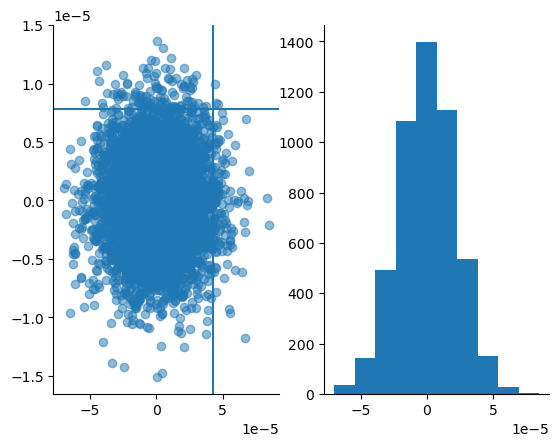

In [3]:
fig, axlist = plt.subplots(1, 2)
axlist[0].scatter(electron_bunch_list[0].x, electron_bunch_list[0].xp, alpha=0.5) 
axlist[0].axvline(2*electron_bunch_list[0].sigma_x())
axlist[0].axhline(2*electron_bunch_list[0].sigma_xp())

print(np.max(electron_bunch_list[0].x)/electron_bunch_list[0].sigma_x())
print(np.max(electron_bunch_list[0].y))


axlist[1].hist(electron_bunch_list[0].x)
for ax in axlist:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

In [4]:
s = np.arange(0, N_SEGMENTS + 1) * CIRCUMFERENCE / N_SEGMENTS
alpha_x, alpha_y = ALPHA_X_SMOOTH * \
    np.ones(N_SEGMENTS), ALPHA_Y_SMOOTH * np.ones(N_SEGMENTS)
beta_x, beta_y = BETA_X_SMOOTH * \
    np.ones(N_SEGMENTS), BETA_Y_SMOOTH * np.ones(N_SEGMENTS)
D_x, D_y = np.zeros(N_SEGMENTS),  np.zeros(N_SEGMENTS)
trans_map = TransverseMap(s, alpha_x, beta_x, D_x,
                              alpha_y, beta_y, D_y, Q_X, Q_Y)

In [5]:
from tqdm.notebook import tqdm
from PyHEADTAIL.field_maps import efields_funcs as efields
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.general import pmath as pm
from scipy.constants import physical_constants
import PyHEADTAIL.aperture.aperture as aperture

r_e = physical_constants['classical electron radius'][0]
class BeamIonElement(Element):
    def __init__(self,  sig_check=True, dist='GS', monitor_name=None, L_sep = 0.85, particle_monitor=False):
        self.dist = dist
        if self.dist == "GS":
            self._efieldn = efields._efieldn_mit
            # self.sig_check = sig_check
        elif self.dist == "LN":
            self._efieldn = efields._efieldn_linearized
        self.L_sep = 0.85
        self.N_MACROPARTICLES = int(30)
        self.N_MACROPARTICLES_MAX = int(5e4)
        self.CIRCUMFERENCE = CIRCUMFERENCE 
        self.N_SEGMENTS = N_SEGMENTS
        if sig_check:
                self._efieldn = efields.add_sigma_check(
                    self._efieldn, self.dist)
        self.n_g = 2.4e13 # was 2.4e13
        self.sigma_i = 1.8e-22
        self.A = 28
        self.index = 0
        self.L_sep = 0.85
        self.charge_state = 1
        self.monitor_name = monitor_name
        self.particle_monitor = particle_monitor

        self.ion_beam = particles.Particles(
                                            macroparticlenumber=1,
                                            particlenumber_per_mp=1,
                                            charge=self.charge_state*e,
                                            mass=self.A*m_p,
                                            circumference=CIRCUMFERENCE,
                                            gamma=1.0001,
                                            coords_n_momenta_dict=
                                            {
                                            'x': np.array([0, ]),
                                            'xp': np.array([0, ]),
                                            'y': np.array([0, ]),
                                            'yp': np.array([0, ]),
                                            'z': np.array([0, ]),
                                            'dp': np.array([0, ])
                                            }
                                            )
        if particle_monitor:
            self.particle_monitor = particle_monitor
            self.ions_monitor = ParticleMonitor(monitor_name,
                                             stride = 1,
                                                parameters_dict=None
                                             )
        elif monitor_name is not None:
            self.monitor_name = monitor_name
            self.ions_monitor = BunchMonitor(monitor_name,
                                             n_steps=H_RF*N_TURNS,
                                             parameters_dict=None,
                                             write_buffer_every=50,
                                             buffer_size=100,
                                             )
        else:
            self.ions_monitor = None
    def get_ion_beam(self):
        return self.ion_beam
    def track(self, electron_bunch):
        '''Tracking method to track interaction between an electron bunch
        and an ion beam (2D electromagnetic field).
        The kicks are performed both for electron beam slice and for an ion beam. 
        Ion beam is tracked in a drift/space-charge of electron bunch sections. 
        
        Interaction is computed via Eqs. (17, 18) of 
        
        Tian, S. K.; Wang, N. (2018). Ion instability in the HEPS storage ring.
        FLS 2018 - Proceedings of the 60th ICFA Advanced Beam Dynamics Workshop on Future Light Sources,
        34–38. https://doi.org/10.18429/JACoW-FLS2018-TUA2WB04
        '''
        if electron_bunch.intensity == 0:
            self.index+=1
            self.ion_beam = particles.Particles(
                                            macroparticlenumber=1,
                                            particlenumber_per_mp=1,
                                            charge=self.charge_state*e,
                                            mass=self.A*m_p,
                                            circumference=CIRCUMFERENCE,
                                            gamma=1.0001,
                                            coords_n_momenta_dict=
                                            {
                                            'x': np.array([0, ]),
                                            'xp': np.array([0, ]),
                                            'y': np.array([0, ]),
                                            'yp': np.array([0, ]),
                                            'z': np.array([0, ]),
                                            'dp': np.array([0, ])
                                            }
                                            )
            if self.particle_monitor:
                self.ions_monitor = ParticleMonitor(self.monitor_name+'{:}'.format(self.index),
                                             stride = 1,
                                                parameters_dict=None
                                             )
            elif self.monitor_name is not None:
                self.ions_monitor = BunchMonitor(self.monitor_name+'{:}'.format(self.index),
                                             n_steps=H_RF*N_TURNS,
                                             parameters_dict=None,
                                             write_buffer_every=50,
                                             buffer_size=100,
                                             )

        if self.ion_beam.macroparticlenumber < self.N_MACROPARTICLES_MAX:
            new_particles = generators.ParticleGenerator(
                                                    macroparticlenumber=self.N_MACROPARTICLES,
                                                    intensity=electron_bunch.intensity*self.sigma_i*self.n_g*self.CIRCUMFERENCE/self.N_SEGMENTS,
                                                    charge=self.charge_state*e,
                                                    gamma=1.0001,
                                                    mass=self.A*m_p,
                                                    circumference=CIRCUMFERENCE,
                                                    # distribution_x=generators.uniform2D(-2*electron_bunch.sigma_x(), 2*electron_bunch.sigma_x()),
                                                    # distribution_y=generators.uniform2D(-2*electron_bunch.sigma_y(), 2*electron_bunch.sigma_y()),
                                                    distribution_x=generators.gaussian2D_asymmetrical(electron_bunch.sigma_x(), electron_bunch.sigma_xp()),
                                                    distribution_y=generators.gaussian2D_asymmetrical(electron_bunch.sigma_y(), electron_bunch.sigma_yp()),
                                                    distribution_z=generators.uniform2D(0, self.CIRCUMFERENCE/self.N_SEGMENTS),
                                                    limit_n_rms_x=3., limit_n_rms_y=3.,
                
                                                    printer=SilentPrinter()
                                                    ).generate()
            # print('{0:.1e}, {1:.1e}'.format(electron_bunch.sigma_x(), new_particles.sigma_x() ))
            # print('{0:.1e}, {1:.1e}'.format(electron_bunch.sigma_y(), new_particles.sigma_y() ))
            
            new_particles.x[:] += electron_bunch.mean_x()
            new_particles.xp[:] = 0
            new_particles.y[:] += electron_bunch.mean_y()
            new_particles.yp[:] = 0
            self.ion_beam += new_particles
        else:
            self.ion_beam.intensity += electron_bunch.intensity*self.sigma_i*self.n_g*self.CIRCUMFERENCE/self.N_SEGMENTS
        prefactor_kick_ion_field =  -(self.ion_beam.intensity*
                                     self.ion_beam.charge*electron_bunch.charge/
                                    (electron_bunch.p0*c))*(electron_bunch.gamma*self.CIRCUMFERENCE/self.N_SEGMENTS)/self.L_sep
        prefactor_kick_electron_field = -(electron_bunch.intensity*
                                          electron_bunch.charge*self.ion_beam.charge/c)
        assert (not np.isnan(prefactor_kick_ion_field)), 'Prefactor to electron kicks is NaN'
        assert (not np.isnan(prefactor_kick_electron_field)), 'Prefactor to ion kicks is NaN'
        apt_xy = aperture.EllipticalApertureXY(x_aper=5*electron_bunch.sigma_x(), y_aper=5*electron_bunch.sigma_y())
        apt_xy.track(self.ion_beam)
        p_id_electrons = electron_bunch.id.copy()-1
        # p_id_ions = self.ion_beam.id.copy()-1 
        p_id_ions = np.linspace(0, self.ion_beam.y.shape[0]-1, self.ion_beam.y.shape[0], dtype=np.int64) 
#Electric field of ions    
        en_ions_x, en_ions_y = self.get_efieldn(
                # pm.take(electron_bunch.x, p_id_electrons),
                electron_bunch.mean_x(),
                # pm.take(electron_bunch.y, p_id_electrons),
                electron_bunch.mean_y(),
                self.ion_beam.mean_x(), self.ion_beam.mean_y(),
                self.ion_beam.sigma_x(), self.ion_beam.sigma_y())
    #Electric field of electrons        
        en_electrons_x, en_electrons_y = self.get_efieldn(
                pm.take(self.ion_beam.x, p_id_ions),
                pm.take(self.ion_beam.y, p_id_ions),
                # self.ion_beam.mean_x(), self.ion_beam.mean_y(),
                electron_bunch.mean_x(),  electron_bunch.mean_y(),
                electron_bunch.sigma_x(), electron_bunch.sigma_y()
        )
        kicks_electrons_x = en_ions_x * prefactor_kick_ion_field
        kicks_electrons_y = en_ions_y * prefactor_kick_ion_field
        kicks_ions_x = en_electrons_x * prefactor_kick_electron_field
        kicks_ions_y = en_electrons_y * prefactor_kick_electron_field
        assert (not np.isnan(kicks_electrons_x.all())), 'kicks_electrons_x is NaN'
        assert (not np.isnan(kicks_electrons_y.all())), 'kicks_electrons_y is NaN'
        assert (not np.isnan(kicks_ions_x.all())), 'kicks_ions_x is NaN'
        assert (not np.isnan(kicks_ions_y.all())), 'kicks_ions_y is NaN'

        kicked_electrons_xp = pm.take(electron_bunch.xp, p_id_electrons) + kicks_electrons_x
        kicked_electrons_yp = pm.take(electron_bunch.yp, p_id_electrons) + kicks_electrons_y

        kicked_ions_xp = pm.take(self.ion_beam.xp, p_id_ions) + kicks_ions_x
        kicked_ions_yp = pm.take(self.ion_beam.yp, p_id_ions) + kicks_ions_y


        pm.put(self.ion_beam.xp, p_id_ions, kicked_ions_xp)
        pm.put(self.ion_beam.yp, p_id_ions, kicked_ions_yp)

        pm.put(electron_bunch.xp, p_id_electrons, kicked_electrons_xp)
        pm.put(electron_bunch.yp, p_id_electrons, kicked_electrons_yp)

        #Drift for the ions in one bucket
        drifted_ions_x = pm.take(self.ion_beam.xp, p_id_ions)*self.L_sep/(self.ion_beam.mass*c)+pm.take(self.ion_beam.x, p_id_ions)
        drifted_ions_y = pm.take(self.ion_beam.yp, p_id_ions)*self.L_sep/(self.ion_beam.mass*c)+pm.take(self.ion_beam.y, p_id_ions)
        
        M_drift = np.array([[1, self.L_sep/(self.ion_beam.mass*c)],[0, 1]])
        y_test = 0.01*electron_bunch.sigma_y()
        K = prefactor_kick_electron_field*self._efieldn(electron_bunch.sigma_x(),
                                                       y_test,
                                                       electron_bunch.sigma_x(),
                                                       electron_bunch.sigma_y())[1]/y_test
        M_linfoc = np.array([[1, 0], [K, 1]])
            
        # assert (electron_bunch.intensity != 0 and np.abs(np.trace(M_linfoc@M_drift)) < 2), 'Ions are not trapped |{0:}| > 2'.format(
        #     np.abs(np.trace(M_linfoc@M_drift),
        #      ))
        pm.put(self.ion_beam.x, p_id_ions, drifted_ions_x)
        pm.put(self.ion_beam.y, p_id_ions, drifted_ions_y)
        self.ions_monitor.dump(self.ion_beam)
    def get_efieldn(self, xr, yr, mean_x, mean_y, sig_x, sig_y):
            '''The charge-normalised electric field components of a
            two-dimensional Gaussian charge distribution according to
            M. Bassetti and G. A. Erskine in CERN-ISR-TH/80-06.

            Return (E_x / Q, E_y / Q).
            '''
            x = xr - mean_x
            y = yr - mean_y

            # absolute values for convergence reasons of erfc
            en_x, en_y = self._efieldn(pm.abs(x), pm.abs(y), sig_x, sig_y)
            en_x = pm.abs(en_x) * pm.sign(x)
            en_y = pm.abs(en_y) * pm.sign(y)

            return en_x, en_y

In [ ]:
trans_one_turn = [m for m in trans_map]
BI = BeamIonElement()
beam_ion_elements = []
for ind, m in enumerate(trans_one_turn):
    if ind == 0:
            beam_ion_elements.append(BeamIonElement(dist='LN', monitor_name='Results/IPM(ind={0:})'.format(int(ind)), particle_monitor=True))
    beam_ion_elements.append(BeamIonElement(dist='LN', monitor_name='Results/IM(ind={0:})'.format(int(ind))))
trans_one_turn = [item for sublist in zip(trans_one_turn, beam_ion_elements) for item in sublist]
print('First 5 elements of a transverse map: ')
for item in trans_one_turn[:5]:
    print(item) 
for turn in tqdm(range(N_TURNS)):
    for index, m_ in enumerate(tqdm(trans_one_turn)):
        for bunch_index, electron_bunch in enumerate(electron_bunch_list):
            m_.track(electron_bunch_list[bunch_index])    
            long_map.track(electron_bunch_list[bunch_index])
            if index % 2 == 0:
                monitor_list[bunch_index].dump(electron_bunch_list[bunch_index])

Results/IPM(ind=0)
First 5 elements of a transverse map: 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
 new_particles = generators.ParticleGenerator(macroparticlenumber=int(1e3),
                                            intensity=INTENSITY_PER_BUNCH*1e-22*2.4e13*CIRCUMFERENCE/H_RF,
                                            charge=e,
                                            gamma=1.0001,
                                            mass=28*m_p,
                                            circumference=CIRCUMFERENCE,
                                            distribution_x=generators.uniform2D(-2*electron_bunch.sigma_x(), 2*electron_bunch.sigma_x()),
                                            distribution_y=generators.uniform2D(-2*electron_bunch.sigma_y(), 2*electron_bunch.sigma_y()),
                                            # distribution_x=generators.gaussian2D_asymmetrical(electron_bunch.sigma_x(), electron_bunch.sigma_xp()),
                                            # distribution_y=generators.gaussian2D_asymmetrical(electron_bunch.sigma_y(), electron_bunch.sigma_yp()),
                                            # limit_n_rms_x=3., limit_n_rms_y=3.,
                                            distribution_z=generators.uniform2D(0, CIRCUMFERENCE/N_SEGMENTS),
                                            printer=SilentPrinter()
                                            ).generate()
new_particles.xp[:] = 0
new_particles.yp[:] = 0

In [ ]:
fig, axlist = plt.subplots(1, 2)
axlist[0].scatter(electron_bunch_list[400].x/electron_bunch_list[400].sigma_x(), electron_bunch_list[400].xp/electron_bunch_list[400].sigma_xp(), alpha=0.5) 
# axlist[0].axvline(2*electron_bunch.sigma_x())
# axlist[0].axvline(electron_bunch.sigma_x())
axlist[0].set_ylim(-3.5, 3.5)
axlist[0].scatter(new_particles.x/electron_bunch_list[400].sigma_x(), new_particles.xp/electron_bunch_list[400].sigma_xp(), alpha=0.1, marker='.')
print('{:.2e}'.format(new_particles.sigma_y()))
print('{:.2e}'.format(electron_bunch_list[0].sigma_y()))
axlist[1].hist(electron_bunch_list[0].y/electron_bunch_list[0].sigma_y(), bins=25)
for ax in axlist:
    ax.set_xlim(-3.5, 3.5)


In [ ]:
ion_cloud = trans_one_turn[1].get_ion_beam()
# fig, ax = plt.subplots(1, 1)
ax = sbs.jointplot(ion_cloud.y/electron_bunch.sigma_y(), ion_cloud.yp, marker='.', alpha=0.5)
ax.ax_joint.set_xlabel('$y$')
ax.ax_joint.set_ylabel('$p_y$')
ax.ax_joint.set_xlim(-15, 15)
ax.ax_joint.set_xlabel('$y_\mathrm{ion}/\sigma_e$')
ax.ax_joint.set_ylim(-10*ion_cloud.sigma_yp(), 10*ion_cloud.sigma_yp())
# ax.ax_joint.set_xlim(-3*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH), 3*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH))
# ax.scatter(ion_cloud.y, ion_cloud.yp, marker='.', alpha=0.5)
# n_bins = int(1+np.log2(ion_cloud.y.shape[0]))
# fig, ax = plt.subplots(1, 1)
# ax.hist(ion_cloud.y, bins=50)
ax.ax_joint.set_xlim(-5, 5)
print('Ion cloud intensity {:.1e}'.format(ion_cloud.intensity))
# fig, ax = plt.subplots(1, 1)
# for ind, ion_cloud in enumerate(trans_one_turn[1::2]): 
    # sigma = ion_cloud.get_ion_beam().sigma_y()
    # ax.scatter(ind, sigma, marker='o')
# ax.set_ylim(0, 10*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH))

In [ ]:
from scipy.special import k0
fig, ax  = plt.subplots(1, 1)
ion_cloud = trans_one_turn[1].get_ion_beam()
ax = sbs.kdeplot(ion_cloud.y/ion_cloud.sigma_y())
sig = .75
x = np.linspace(-6, 6)
y = 1/np.sqrt(2*pi*sig**2)*np.exp(-x**2/2/sig**2)
ax.plot(x, y)
# def get_n_i(r, a):
#     Sigma_I = 1e-22
#     n_g = 2.4e13
#     return 2*np.sign(r)*Sigma_I*n_g*INTENSITY_PER_BUNCH/(pi*a)**2*np.sqrt(a**2-r**2)/r
# def get_dist(x, sig_x):
#     return 1/(pi*np.sqrt(2*pi)*sig_x)*k0(x**2/sig_x**2)*np.exp(-x**2/sig_x**2)
# r = np.linspace(min(ion_cloud.y), max(ion_cloud.y), 100)
# # ax.plot(r, get_n_i(r, 2*ion_cloud.sigma_y())/2.5e6)
# x = np.linspace(min(ion_cloud.y), max(ion_cloud.y), 100)
# # ax.plot(x, get_dist(x, electron_bunch.sigma_y()))